# Tutorial 3: Dual Spaces and Hilbert Space Design

In the last tutorial, we saw how the `HilbertSpace` class provides a unified interface for different kinds of vector spaces. Now, we'll explore the theoretical engine that makes this possible: the concept of a **dual space**.

### The Theory in Outline

For any `HilbertSpace`, $X$, its **dual space**, $X'$, is the space of all continuous linear maps from $X$ to the real numbers. We call these maps "linear functionals" or "dual vectors." In this library, they are represented by the `LinearForm` class.

The **Riesz representation theorem** guarantees that for every dual vector $x' \in X'$, there is a unique corresponding vector $x \in X$. The map $J_X: X \to X'$ that connects a vector to its dual representation is the **Riesz representation map**. This library uses a powerful design pattern where the inner product on $X$ is defined *implicitly* by this map and the natural **duality product** between the primal and dual spaces.

The relationship is as follows:
$$
\langle x, y \rangle_X = \langle J_X(x), y \rangle
$$
where $\langle \cdot, \cdot \rangle_X$ is the inner product on the primal space, and $\langle \cdot, \cdot \rangle$ is the duality product (the action of a `LinearForm` on a vector). In the library's syntax, this translates to:

`space.inner_product(x, y) == space.duality_product(space.to_dual(x), y)`

In this tutorial, we will:
1.  Explore the `LinearForm` class.
2.  Use the `dirac` functional as a concrete, non-trivial example of a `LinearForm` and its Riesz representation.
3.  Recreate the `EuclideanSpace` class from scratch to demonstrate how the abstract `HilbertSpace` methods work.
4.  Show how to create a non-standard inner product using `MassWeightedHilbertSpace`.

In [1]:
# To run in colab, uncomment the line below to install pygeoinf. 
#%pip install pygeoinf

import numpy as np
import matplotlib.pyplot as plt
import pygeoinf as inf
from pygeoinf.symmetric_space.circle import Sobolev

## 1. The `LinearForm` (Dual Vectors)

A `LinearForm` is the library's object for representing a linear functional. You can create one in two ways:
* **By `mapping`:** You provide a function that takes a vector and returns a number. This is conceptually clear.
* **By `components`:** You provide the component vector for the `LinearForm` directly. This is usually more convenient and computationally efficient.

In [2]:
# We'll use a Sobolev space on a circle for our examples
space = Sobolev.from_sobolev_parameters(2.0, 0.1)
x = space.random() # A random function vector

# --- Create a LinearForm by mapping ---
# This form finds the integral of a function
integral_form = inf.LinearForm(space, mapping=lambda u: np.mean(u))
print(f"Integral of random function x: {integral_form(x):.4f}")

# --- Create a LinearForm by components ---
# Let's get the components of the integral form and create a new one
integral_form_by_comp = inf.LinearForm(space, components=integral_form.components)
print(f"Integral computed by component-defined form: {integral_form_by_comp(x):.4f}")

Integral of random function x: 0.7539
Integral computed by component-defined form: 0.7539


## 2. The Riesz Map and the Dirac Functional

A perfect example of these concepts is the **Dirac delta functional**, $\delta_p$, which evaluates a function at a specific point $p$.

* The `dirac(p)` method on a `Sobolev` space returns a `LinearForm` that represents $\delta_p$. Its `.components` define how to perform point evaluation.
* The `dirac_representation(p)` method returns the Riesz representation of that functional. This is the unique vector in the original `Sobolev` space that represents $\delta_p$. Let's call it $u_p$.

The Riesz map guarantees that applying the functional is the same as taking the inner product with its representation: $\delta_p(f) = \langle u_p, f \rangle$.

Evaluation using the LinearForm: f(1.57) = 1.0000
Evaluation using the inner product: <u_p, f> = 1.0000


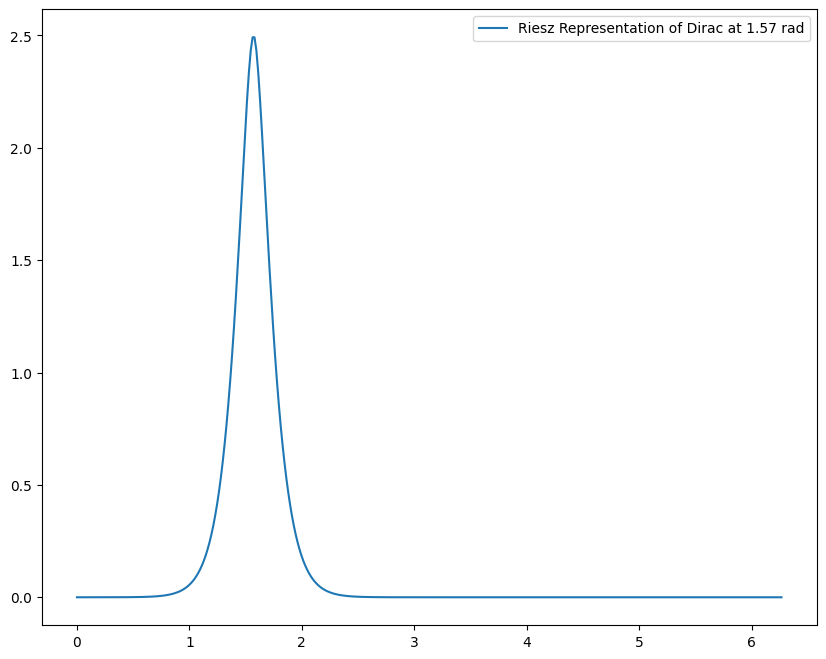

In [3]:
# An angle on the circle
test_point = np.pi / 2

# Get the LinearForm for point evaluation at test_point
dirac_form = space.dirac(test_point)

# Get the Riesz representation of this form (a vector in the Sobolev space)
dirac_vector_representation = space.dirac_representation(test_point)

# Create a test function, f(theta) = sin(theta)
test_func_vec = space.project_function(np.sin)

# --- Compare the two ways of evaluating the function ---

# 1. Applying the LinearForm directly
evaluation_by_form = dirac_form(test_func_vec)
print(f"Evaluation using the LinearForm: f({test_point:.2f}) = {evaluation_by_form:.4f}")

# 2. Taking the inner product with the Riesz representation
evaluation_by_inner_product = space.inner_product(dirac_vector_representation, test_func_vec)
print(f"Evaluation using the inner product: <u_p, f> = {evaluation_by_inner_product:.4f}")

# The true value is sin(pi/2) = 1.0
assert np.isclose(evaluation_by_form, 1.0)
assert np.isclose(evaluation_by_inner_product, 1.0)

# We can plot the Riesz representation of the Dirac functional.
# It's a smooth function that peaks at the test point.
fig, ax = space.plot(dirac_vector_representation, label=f'Riesz Representation of Dirac at {test_point:.2f} rad')
ax.legend()
plt.show()

## 3. Building a Hilbert Space From Scratch

The power of the library's design is that a `HilbertSpace` is completely defined by a handful of abstract methods. Let's demonstrate this by recreating a simple `EuclideanSpace` from scratch.

All we need to do is subclass `HilbertSpace` and implement the six abstract methods: `dim`, `to_components`, `from_components`, `to_dual`, and `from_dual`, `__eq__`. All other functionality (`inner_product`, `norm`, `.random()`, etc.) will then work automatically.

In [4]:
class MyEuclideanSpace(inf.HilbertSpace):
    """A custom implementation of EuclideanSpace."""
    def __init__(self, dim: int):
        self._dim = dim

    @property
    def dim(self) -> int:
        return self._dim

    def to_components(self, x: np.ndarray) -> np.ndarray:
        # For EuclideanSpace, the vector IS its component array.
        return x

    def from_components(self, c: np.ndarray) -> np.ndarray:
        # The component array IS the vector.
        return c

    def to_dual(self, x: np.ndarray) -> "LinearForm":
        # The Riesz map is the identity: a vector's dual form
        # has the same components as the vector itself.
        return inf.LinearForm(self, components=x)

    def from_dual(self, xp: "LinearForm") -> np.ndarray:
        # The inverse Riesz map is also the identity.
        return xp.components

    def __eq__(self, other: object):
        if not isinstance(other, EuclideanSpace):
            return NotImplemented
        return self.dim == other.dim


# --- Let's test our new class ---
my_space = MyEuclideanSpace(3)
x = my_space.random()
y = my_space.random()

# These methods work even though we didn't explicitly define them!
inner_prod = my_space.inner_product(x, y)
norm_x = my_space.norm(x)

print(f"Our custom space has dimension: {my_space.dim}")
print(f"A random vector x: {x}")
print(f"The inner product <x, y> is: {inner_prod:.4f}")
print(f"The NumPy dot product x . y is: {np.dot(x, y):.4f}")

assert np.isclose(inner_prod, np.dot(x, y))

Our custom space has dimension: 3
A random vector x: [-0.93990874 -0.03045761  0.92734972]
The inner product <x, y> is: -0.2895
The NumPy dot product x . y is: -0.2895


## 4. Creating a Non-Standard Inner Product

The real power of this design shines when we want to use a non-standard inner product. The `MassWeightedHilbertSpace` class does exactly this. It takes an existing space and a "mass operator" `M` to define a new inner product:

$$
\langle x, y \rangle_{new} = \langle M x, y \rangle_{old}
$$

Let's use our custom `MyEuclideanSpace` as the underlying space and define a new weighted inner product.

In [5]:
# The underlying space
base_space = MyEuclideanSpace(2)

# A mass matrix (must be symmetric and positive-definite)
mass_matrix = np.array([[2.0, 0.5],
                        [0.5, 1.0]])

# Create LinearOperators for the mass matrix and its inverse
mass_op = inf.LinearOperator.from_matrix(base_space, base_space, mass_matrix, galerkin=True)
inv_mass_op = inf.LinearOperator.from_matrix(base_space, base_space, np.linalg.inv(mass_matrix), galerkin=True)

# Create the mass-weighted space
weighted_space = inf.MassWeightedHilbertSpace(base_space, mass_op, inv_mass_op)

# --- Compare the inner products ---
x = np.array([1.0, 0.0])
y = np.array([0.0, 1.0])

# Standard inner product (should be 0)
base_inner_prod = base_space.inner_product(x, y)
print(f"Base space inner product <x, y>: {base_inner_prod:.4f}")

# Weighted inner product (should NOT be 0)
weighted_inner_prod = weighted_space.inner_product(x, y)
print(f"Weighted space inner product <x, y>: {weighted_inner_prod:.4f}")

# Manually compute the weighted inner product: (M @ x) . y
manual_result = np.dot(mass_matrix @ x, y)
print(f"Manual calculation (M@x).y: {manual_result:.4f}")

assert np.isclose(weighted_inner_prod, manual_result)

Base space inner product <x, y>: 0.0000
Weighted space inner product <x, y>: 0.5000
Manual calculation (M@x).y: 0.5000
